# Materials associated with the paper: 

Cao, W., Williams, S., Flament, N., Zahirovic, S., Scotese, C., and Müller, R. D., 2018. Paleolatitudinal distribution of lithologic indicators of climate in a paleogeographic framework. Geological Magazine, 1-24. doi:10.1017/S0016756818000110.

### This Jupyter notebook is used to generate Figure 13 in the paper.

The code in this notebook is written in Python 2.7. It utilises the standard scientific Python modules including numpy, pandas, healpy, os, matplotlib, mpl_toolkits and the open source modules pygplates which provides a Python API to the GPlates software (https://www.gplates.org/).

In [1]:
import pygplates
#import sphere_interp_kdtree as sphi
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os

%matplotlib inline

In [1]:
#rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'
#rotation_filename = '/Users/wenchaocao/Desktop/New_Rotation.rot'
rotation_filename = '/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Rotations/Global_EB_410-0Ma_GK07_Matthews_etal_PMAG_fixed_crossovers.rot'

rotation_model = pygplates.RotationModel(rotation_filename)

### Make a multipoint feature (using healpix)
### with evely points distributed points on the sphere
# Note the number here controls resolution: 
# higher number--> higher resolution + slower code execution
nSide = 128
othetas,ophis = hp.pix2ang(nSide,np.arange(12*nSide**2))
othetas = np.pi/2-othetas
ophis[ophis>np.pi] -= np.pi*2
lats = np.degrees(othetas) 
lons = np.degrees(ophis)

multi_point_features = []
multi_point_feature = pygplates.Feature()
multi_point = pygplates.MultiPointOnSphere(zip(lats,lons))  
multi_point_feature.set_geometry(multi_point)
multi_point_feature.set_shapefile_attribute('Layer','do')
multi_point_features.append(multi_point)

mpf = pygplates.FeatureCollection(multi_point_feature)

# save the number of points covering the entire Earth to a variable,
# so that we can use it later to determine the ratio of Earth's surface
# covered by different paleo-environments
num_points_on_globe = lats.shape[0]
print num_points_on_globe

#plot all points on the sphere
#m = Basemap(projection='moll', lon_0=0, resolution='c')
#x,y = m(lons, lats)
#m.plot(x, y,'green', markersize=2)
#plt.show()

196608


In [2]:
def PaleogeogAreas(rotation_model,reconstruction_time,icesheet,mountain,landmass,shallow_marine):
# This function takes filenames for polygon files defining four different paleo-environment
# classes, and a multi-point feature with points covering the Earth's surface (presumably
# generated by healpix to ensure equal-area distribution, though they don't have to be)
# The function maps the paleo-environment attributes from the polygons onto the points
# (as shapefile_attributes) using pygplates plate partioning, and returns the cookie-cut
# points
    
    paleogeog_polygons = []

    if os.path.isfile(icesheet):
        features = pygplates.FeatureCollection(icesheet)
        for feature in features:
            feature.set_shapefile_attribute('Layer','i')
            paleogeog_polygons.append(feature)
    else:
        print 'No ice sheet found'

    features = pygplates.FeatureCollection(mountain)
    for feature in features:
        feature.set_shapefile_attribute('Layer','m')
        paleogeog_polygons.append(feature)

    features = pygplates.FeatureCollection(landmass)
    for feature in features:
        feature.set_shapefile_attribute('Layer','lm')
        paleogeog_polygons.append(feature)

    features = pygplates.FeatureCollection(shallow_marine)
    for feature in features:
        feature.set_shapefile_attribute('Layer','sm')
        paleogeog_polygons.append(feature)

    plate_partitioner = pygplates.PlatePartitioner(paleogeog_polygons,rotation_model,reconstruction_time=reconstruction_time,
                                                  sort_partitioning_plates=None)

    cookie_cut_points = plate_partitioner.partition_features(mpf,
                                                            properties_to_copy=[pygplates.PropertyName.gpml_shapefile_attributes])

    return cookie_cut_points

In [3]:
def PlotPaleogeography(cookie_cut_points,filename):
   
    landmass_point_count = 0.
    mountain_point_count = 0.
    icesheet_point_count = 0.
    shallow_marine_point_count = 0.
    
    yedges = np.arange(-90,91,5)

    lmX = []
    lmY = []
    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='lm':
            for geometry in feature.get_all_geometries():                
                lmX.append(geometry.to_lat_lon_array()[:,1])
                lmY.append(geometry.to_lat_lon_array()[:,0])
                
                landmass_point_count += len(geometry.to_lat_lon_array()[:,1])
    
    smX = []
    smY = []
    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='sm':
            for geometry in feature.get_all_geometries():
                shallow_marine_point_count += len(geometry.to_lat_lon_array()[:,1])
                
                smX.append(geometry.to_lat_lon_array()[:,1])
                smY.append(geometry.to_lat_lon_array()[:,0])
                
    mX = []
    mY = []
    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='m':
            for geometry in feature.get_all_geometries():
                mountain_point_count += len(geometry.to_lat_lon_array()[:,1])
                
                mX.append(geometry.to_lat_lon_array()[:,1])
                mY.append(geometry.to_lat_lon_array()[:,0])
    
    iY = []
    iX = []
    for feature in cookie_cut_points:
        if feature.get_shapefile_attribute('Layer')=='i':
            for geometry in feature.get_all_geometries():
                
                iX.append(geometry.to_lat_lon_array()[:,1])
                iY.append(geometry.to_lat_lon_array()[:,0])

                icesheet_point_count += len(geometry.to_lat_lon_array()[:,1])
                
    
    mountain_Y = np.histogram(np.hstack(mY),bins=yedges)
    
    shallowmarine_Y = np.histogram(np.hstack(smY),bins=yedges)

    landmass_Y = np.histogram(np.hstack(lmY),bins=yedges)
    
    emergedland = []
    
    if icesheet_point_count != 0:
        icesheet_Y = np.histogram(np.hstack(iY),bins=yedges)
        
        emergedland = lmY+mY+iY
        emergedland_Y = np.histogram(np.hstack(emergedland),bins=yedges)
    
    else:
        icesheet_Y = np.zeros((2,36))
        emergedland = lmY+mY
        emergedland_Y = np.histogram(np.hstack(emergedland),bins=yedges)
    
    return mountain_Y,landmass_Y,shallowmarine_Y,icesheet_Y,emergedland_Y

### 1.Calculate paleogeography area before gaps fixed, before modified and after modified

In [4]:
Data = pd.read_csv('/Users/wenchaocao/Research/5_ConsistencyRatios_Fossils_Paleogeog/ReconPaleogeog_EB2015v1_AfterModifiedBasedOnFossils_410_2Ma/ReconPaleogeog_EB2015v1_AfterModifiedOnFossils_TestByFossils_410_2Ma.csv', delimiter=',')  
reconstruction_time_list = Data['Time intervals']
FigNum_list = np.arange(64,17,-2)
FromAge_list = Data['From_age']
ToAge_list = Data['To_age']

reconstruction_time = []
FigNum = []
FromAge= []
ToAge= []

mY_all = np.zeros((36,24))
smY_all = np.zeros((36,24))
iY_all = np.zeros((36,24))
lmY_all = np.zeros((36,24))
elY_all = np.zeros((36,24))

for i,reconstruction_time,FigNum,FromAge,ToAge in zip(np.arange(0,25,1),reconstruction_time_list,FigNum_list,FromAge_list,ToAge_list):
    print i,reconstruction_time,FigNum,FromAge,ToAge
    
    # Matthews2016 paleogeog
    basedir = '/Users/wenchaocao/Research/6_CookieCutting_Corrections/'+str(reconstruction_time)+'/16_PresentDay_Paleogeog_Matthews2016_'+str(reconstruction_time)+'Ma_Corrected/'
    
    icesheet =  '%s/i_fig%d_%d_%d_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)
    mountain =  '%s/m_fig%d_%d_%d_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)
    landmass = '%s/lm_fig%d_%d_%d_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)
    shallow_marine = '%s/sm_fig%d_%d_%d_%0.2fMa.shp' % (basedir,FigNum,FromAge,ToAge,reconstruction_time)
    
    cookie_cut_points = PaleogeogAreas(rotation_model,reconstruction_time,icesheet,mountain,landmass,shallow_marine)
    mountain_Y,landmass_Y,shallowmarine_Y,icesheet_Y,emergedland_Y = PlotPaleogeography(cookie_cut_points,'paleogeog_equal_area_points_%0.2f.png' % reconstruction_time)
    print mountain_Y
    
    mY_all[:,i] = np.array(mountain_Y[0])
    smY_all[:,i] = np.array(shallowmarine_Y[0])
    iY_all[:,i] = np.array(icesheet_Y[0])
    lmY_all[:,i] = np.array(landmass_Y[0])
    elY_all[:,i] = np.array(emergedland_Y[0])
    

0 6 64 11 2
(array([   0,   66,  203,  352,  474,   38,   27,   76,   75,  114,  108,
        217,  173,  302,  376,  460,  458,  329,  492,  615,  232,  202,
        244,  882, 1265, 1127,  552,  405,  422,  386,  634,  374,   45,
         11,    0,    0]), array([-90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30,
       -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,  25,  30,  35,
        40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90]))
1 14 62 20 11
(array([ 103,  288,  193,  336,  250,  102,   48,   34,   41,  138,  112,
        211,  283,  479,  619,  398,  363,  378,  607,  520,  319,  312,
        613, 1277, 1304, 1391,  542,  377,  434,  318,  503,  424,  183,
         20,    0,    0]), array([-90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30,
       -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,  25,  30,  35,
        40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90]))
2 22 60 29 20
(array([   0,   18,  325,  288,   34,    8,   53, 

In [5]:
df = pd.DataFrame(smY_all)
writer = pd.ExcelWriter('smY_all.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

df = pd.DataFrame(mY_all)
writer = pd.ExcelWriter('mY_all.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

df = pd.DataFrame(lmY_all)
writer = pd.ExcelWriter('lmY_all.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

df = pd.DataFrame(elY_all)
writer = pd.ExcelWriter('elY_all.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

df = pd.DataFrame(iY_all)
writer = pd.ExcelWriter('iY_all.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline

# data two bias removed before flipping
data_coal = pd.read_excel('/Users/wenchaocao/Research/21_Python/1_BG/mY_all.xlsx')
print data_coal


      0     1     2    3    4    5    6    7    8    9  ...    14   15   16  \
0     12    54     0   58   57   23  260  203  130   96 ...     0   34    0   
1     91   298    47  228  155  256  279  325  538   41 ...     0   34   74   
2    180   223   232  416   70  229  374  309  290  412 ...     0   21  169   
3    328   371   266  426  293  295  373  298  260  350 ...     0   83  188   
4    485   294    78   60  109  161  308  122   93  212 ...    73   48  138   
5     28    29    41   26   44  140   55   44   64   59 ...    81   13   67   
6      0     3     0   43   35   50    9   28   45   30 ...    25    4  102   
7     74    59    61   91   32   67   47   33   44   61 ...    11   18  114   
8     91   131    46   42   45   58   79   42   32   21 ...    22    2   57   
9     97    37    26   34   59  110  216   75   43    7 ...     5    0   23   
10    90    62    24   74   39   69  176   24   34    0 ...     0   11   15   
11   223   164    46   76   44   55  343   95   29  

<function matplotlib.pyplot.show>

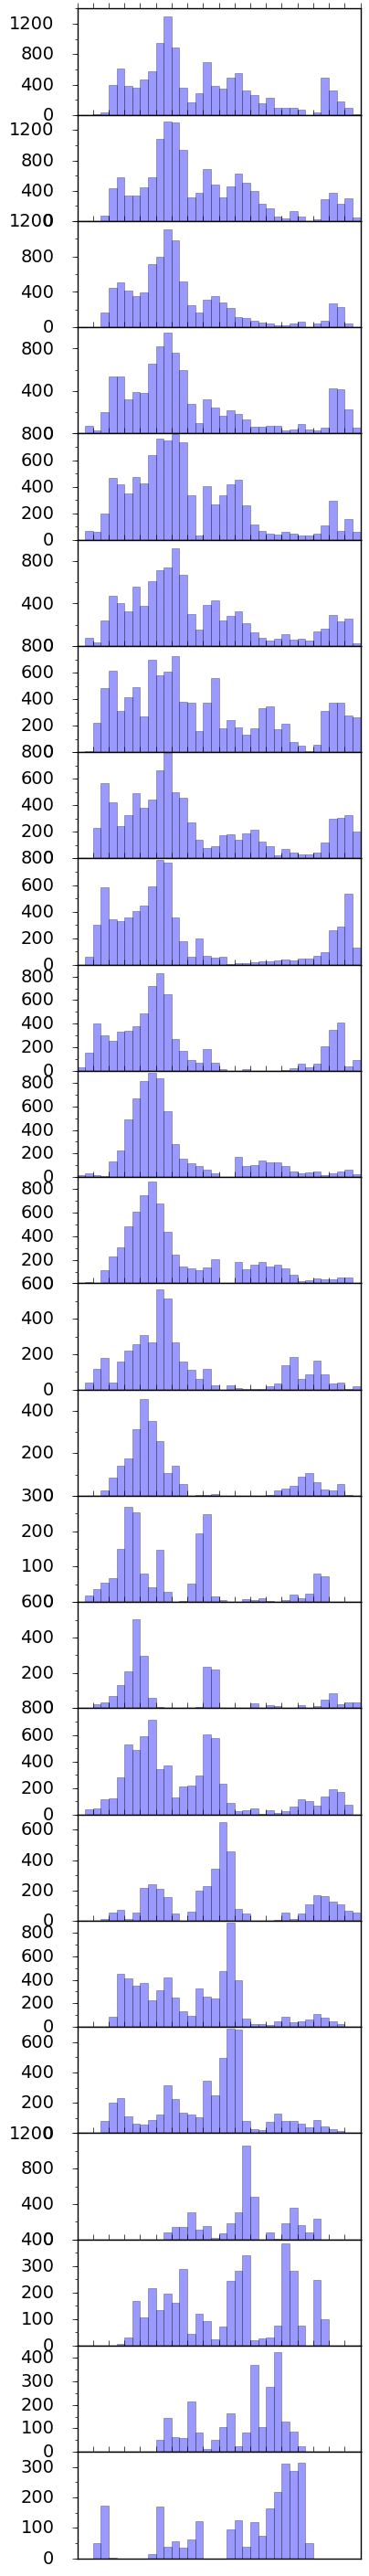

In [76]:
fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36))

for i in np.arange(0,24,1):
    
    ################################################
    # binning size: 5 degree
    xedges = np.arange(-180, 181, 5) #longtitude
    yedges = np.arange(-90, 91, 5) #latitude, specify the bin size

    # Coals, evaporites and glacial deposits
    axes[i].bar(np.array(yedges[:-1]), data_coal.iloc[:,i], width=5, color='blue',linewidth=0.5,alpha=0.4) #edgecolor='grey',
    
    axes[i].set_xticks(np.arange(-90, 91, 10))
    axes[i].set_xticklabels([])
    axes[i].set_xlim((90,-90))
    axes[i].set_ylim(ymin=0)
    axes[i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50

    axes[i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[i].xaxis.set_ticks_position('top') # bottom
    axes[i].set_yticks(axes[i].get_yticks()[::2]) # set the major ticks
    interval = np.diff(axes[i].get_yticks())[0]
    axes[i].yaxis.set_minor_locator(MultipleLocator(interval/2))
    axes[i].tick_params(which = 'both', direction = 'out') # if only want to set y-axis: axes[1,2].yaxis.set_tick_params(labelsize=12,direction='out')
    axes[i].yaxis.set_ticks_position('left')

fig.subplots_adjust(hspace=0.00)
plt.savefig('Mountain_Distribution.pdf',dpi=600)
plt.show





0       12
1       91
2      187
3      358
4      874
5      643
6      384
7      436
8      552
9      677
10    1037
11    1524
12    1048
13     615
14     488
15     838
16    1182
17     731
Name: 0, dtype: int64
0       54
1      298
2      228
3      445
4      733
5      602
6      338
7      400
8      578
9      620
10    1144
11    1477
12    1529
13    1343
14     819
15    1004
16    1137
17     801
Name: 1, dtype: int64
0        0
1       47
2      232
3      431
4      522
5      553
6      412
7      419
8      442
9      743
10     824
11    1149
12    1033
13     591
14     354
15     281
16     532
17     638
Name: 2, dtype: int64
0       58
1      304
2      446
3      629
4      601
5      561
6      368
7      484
8      425
9      692
10     892
11    1024
12     830
13     664
14     410
15     280
16     548
17     416
Name: 3, dtype: int64
0      57
1     221
2     133
3     490
4     572
5     461
6     382
7     503
8     468
9     696
10    803
11    795


<function matplotlib.pyplot.show>

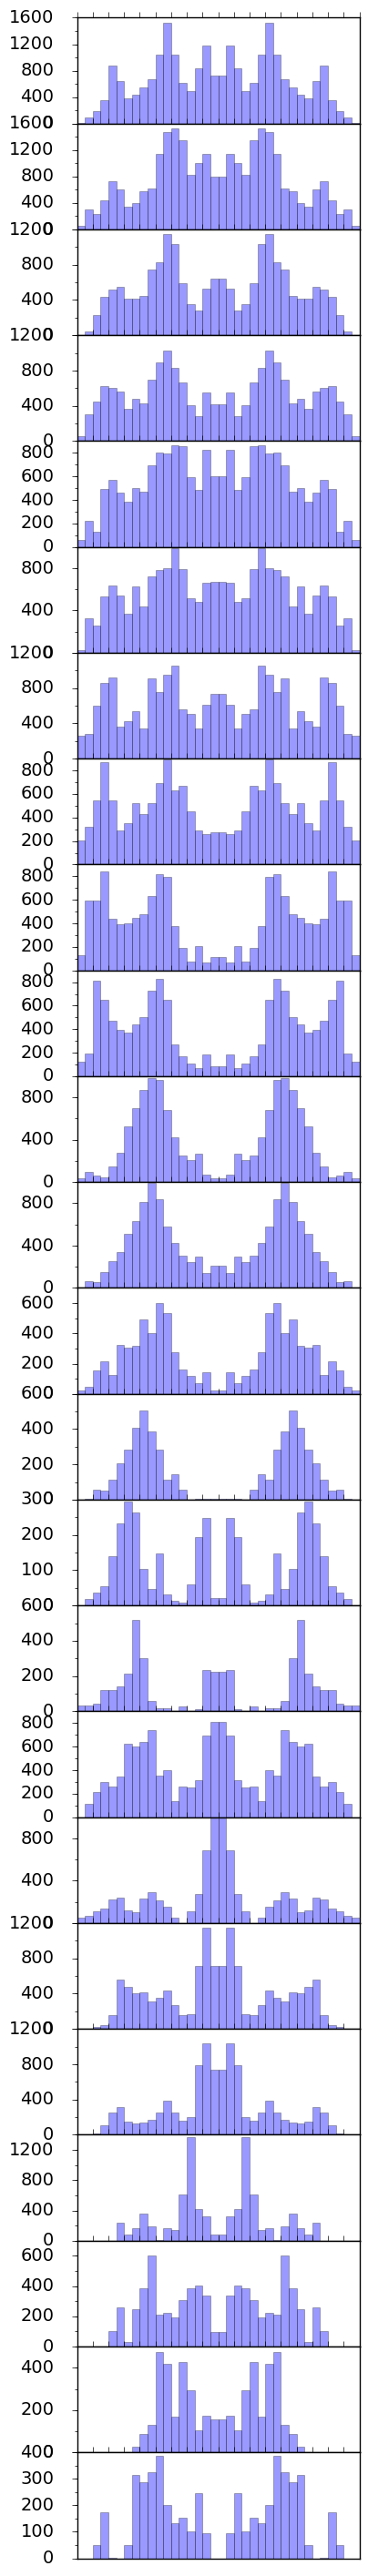

In [134]:
fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36))

data_doubled_all = np.zeros((36,24))
data_filpped_all = np.zeros((18,24))

for i in np.arange(0,24,1):
    
    ################################################
    # binning size: 5 degree
    xedges = np.arange(-180, 181, 5) #longtitude
    yedges = np.arange(-90, 91, 5) #latitude, specify the bin size
    
    data_filpped = data_coal.iloc[:18,i]+np.flipud(data_coal.iloc[18:,i])
    print data_filpped
    data_filpped_all[:,i]=np.array(data_filpped)
    
    data_doubled = list(data_filpped)+list(np.flipud(data_filpped))
    data_doubled_all[:,i]=np.array(data_doubled)
    
    # Coals, evaporites and glacial deposits
    axes[i].bar(np.array(yedges[:-1]), data_doubled, width=5, color='blue',linewidth=0.5,alpha=0.4) #edgecolor='grey',
    
    axes[i].set_xticks(np.arange(-90, 91, 10))
    axes[i].set_xticklabels([])
    axes[i].set_xlim((90,-90))
    axes[i].set_ylim(ymin=0)
    axes[i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50

    axes[i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[i].xaxis.set_ticks_position('top') # bottom
    axes[i].set_yticks(axes[i].get_yticks()[::2]) # set the major ticks
    interval = np.diff(axes[i].get_yticks())[0]
    axes[i].yaxis.set_minor_locator(MultipleLocator(interval/2))
    axes[i].tick_params(which = 'both', direction = 'out') # if only want to set y-axis: axes[1,2].yaxis.set_tick_params(labelsize=12,direction='out')
    axes[i].yaxis.set_ticks_position('left')

fig.subplots_adjust(hspace=0.00)
#plt.savefig('Mountain_ZonalPattern.pdf',dpi=600)
plt.show



In [136]:
df = pd.DataFrame(data_doubled_all)
writer = pd.ExcelWriter('mY_all_Doubled.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

df = pd.DataFrame(data_filpped_all)
writer = pd.ExcelWriter('mY_all_Flipped.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

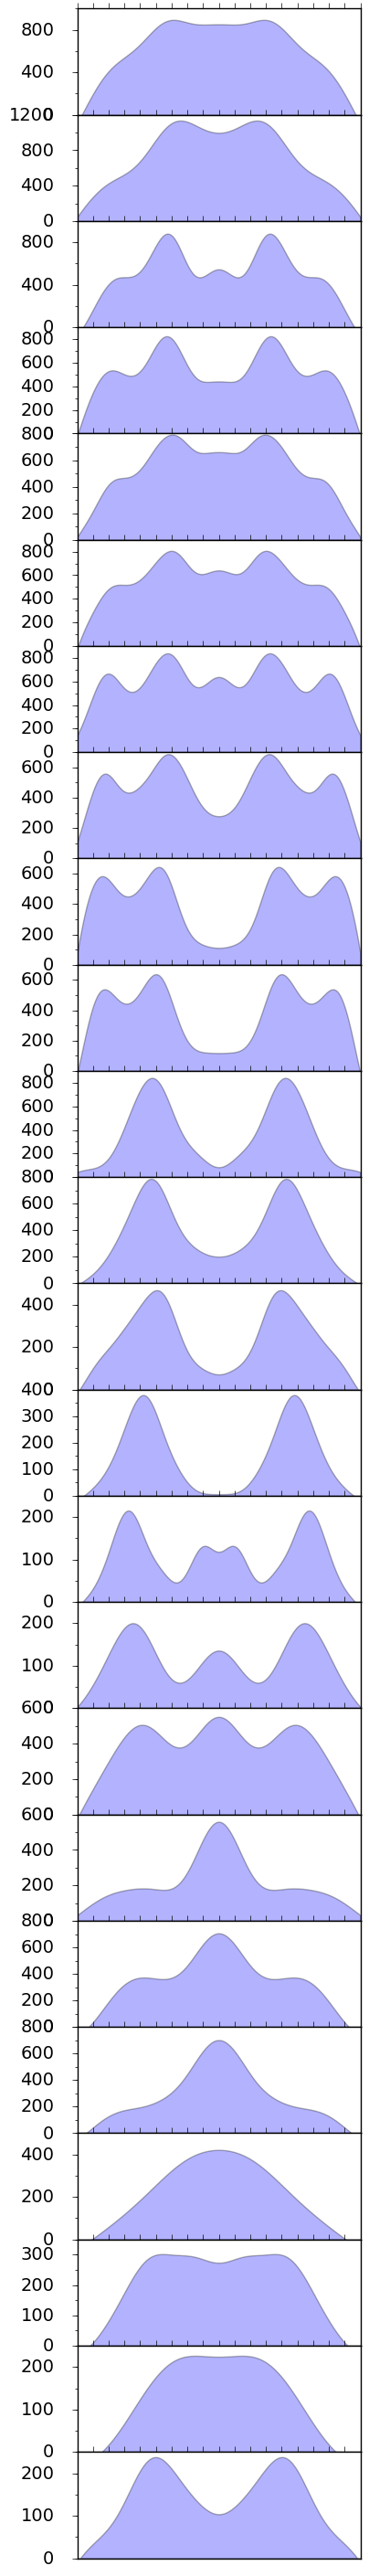

In [82]:
fig, axes = plt.subplots(nrows=24, ncols=1,figsize=(4, 36))

for i in np.arange(0,24,1):
    yedges = np.arange(-90, 91, 5) #latitude
    
    ##############################################
    # Matthews2016
    # Coals
    data = pd.read_table('/Users/wenchaocao/Research/33_MatLab/Library/Feature_modified/Smoothing/MountainRange_Matthews2016_ZonalPattern/Data_XY_BestFitting_'+str(i)+'.txt',header=None, delimiter=r"\s+")
    axes[i].fill_between(data.iloc[:,0],0,data.iloc[:,1],facecolor='blue', interpolate=False, alpha=0.3) #,linewidth=2.0
    
    axes[i].set_xticks(np.arange(-90, 91, 10))
    axes[i].set_xticklabels([])
    axes[i].set_xlim((90,-90))
    axes[i].set_ylim(ymin=0)
    axes[i].xaxis.set_tick_params(direction='out') #labelsize=12,
    #plt.setp(axes[i].get_xticklabels(), fontsize=12.) #,rotation=50
    axes[i].yaxis.set_tick_params(labelsize=14,direction='out') #
    axes[i].xaxis.set_ticks_position('top') # bottom
    axes[i].set_yticks(axes[i].get_yticks()[::2]) # set the major ticks
    interval = np.diff(axes[i].get_yticks())[0]
    axes[i].yaxis.set_minor_locator(MultipleLocator(interval/2))
    axes[i].tick_params(which = 'both', direction = 'out') # if only want to set y-axis: axes[1,2].yaxis.set_tick_params(labelsize=12,direction='out')
    axes[i].yaxis.set_ticks_position('left')
    
    
fig.subplots_adjust(hspace=0.00)
plt.savefig('MountainRange_SiZerCurves_Filled.pdf')
plt.show()

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline

mY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/mY_all.xlsx')
m = np.array(mY_raw)

lmY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/lmY_all.xlsx')
lm = np.array(lmY_raw)

i_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/iY_all.xlsx')
iY = np.array(i_raw)

sm_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/smY_all.xlsx')
sm = np.array(sm_raw)

elY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/elY_all.xlsx')
elY = np.array(elY_raw)


In [62]:
lm_filpped = np.zeros((18,24))
for i in np.arange(0,24,1):
    lm_filpped[:,i] = lm[:18,i]+np.flipud(lm[18:,i])
print len(lm_filpped)

df = pd.DataFrame(lm_filpped)
writer = pd.ExcelWriter('lm_filpped.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


m_filpped = np.zeros((18,24))
for i in np.arange(0,24,1):
    m_filpped[:,i] = m[:18,i]+np.flipud(m[18:,i])
print len(m_filpped)

df = pd.DataFrame(m_filpped)
writer = pd.ExcelWriter('m_filpped.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


iY_filpped = np.zeros((18,24))
for i in np.arange(0,24,1):
    iY_filpped[:,i] = iY[:18,i]+np.flipud(iY[18:,i])
print len(iY_filpped)

df = pd.DataFrame(iY_filpped)
writer = pd.ExcelWriter('iY_filpped.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


sm_filpped = np.zeros((18,24))
for i in np.arange(0,24,1):
    sm_filpped[:,i] = sm[:18,i]+np.flipud(sm[18:,i])
print len(sm_filpped)

df = pd.DataFrame(sm_filpped)
writer = pd.ExcelWriter('sm_filpped.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


elY_filpped = np.zeros((18,24))
for i in np.arange(0,24,1):
    elY_filpped[:,i] = elY[:18,i]+np.flipud(elY[18:,i])
print len(elY_filpped)

df = pd.DataFrame(elY_filpped)
writer = pd.ExcelWriter('elY_filpped.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

18
18
18
18
18


In [10]:

lm_addup = []
for i in np.arange(0,18,1)[0:18:2]:
    print i
    lm_addup.append(list(lm_filpped[i,:] + lm_filpped[i+1,:]))

df = pd.DataFrame(np.array(lm_addup))
writer = pd.ExcelWriter('lm_filpped_addup.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

0
2
4
6
8
10
12
14
16


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline


mY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/m_filpped.xlsx')
m = np.array(mY_raw)

lmY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/lm_filpped.xlsx')
lm = np.array(lmY_raw)

i_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/iY_filpped.xlsx')
Ice = np.array(i_raw)

sm_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/sm_filpped.xlsx')
sm = np.array(sm_raw)


elY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/elY_filpped.xlsx')
el = np.array(elY_raw)



In [64]:
m_addup = []
for i in np.arange(0,18,1)[0:18:2]:
    print m[i,:]
    m_addup.append(list(m[i,:] + m[i+1,:]))

df = pd.DataFrame(np.array(m_addup))
writer = pd.ExcelWriter('m_filpped_addup.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


lm_addup = []
for i in np.arange(0,18,1)[0:18:2]:
    print lm[i,:]
    lm_addup.append(list(lm[i,:] + lm[i+1,:]))

df = pd.DataFrame(np.array(lm_addup))
writer = pd.ExcelWriter('lm_filpped_addup.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


Ice_addup = []
for i in np.arange(0,18,1)[0:18:2]:
    print Ice[i,:]
    Ice_addup.append(list(Ice[i,:] + Ice[i+1,:]))

df = pd.DataFrame(np.array(Ice_addup))
writer = pd.ExcelWriter('Ice_filpped_addup.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


sm_addup = []
for i in np.arange(0,18,1)[0:18:2]:
    print sm[i,:]
    sm_addup.append(list(sm[i,:] + sm[i+1,:]))

df = pd.DataFrame(np.array(sm_addup))
writer = pd.ExcelWriter('sm_filpped_addup.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()


el_addup = []
for i in np.arange(0,18,1)[0:18:2]:
    print el[i,:]
    el_addup.append(list(el[i,:] + el[i+1,:]))

df = pd.DataFrame(np.array(el_addup))
writer = pd.ExcelWriter('el_filpped_addup.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

[  0 103   0  12   0   1  31 229 137 141  26   6  20   0  83  47   0   0
   0   0   0   0   0   0]
[214 213 350 629 270 299 570 676 723 428 130  57  84  95  53 131 213  59
   0   0   0   0   0   0]
[848 674 432 471 444 494 525 484 392 280 201 256 355 291 190 114 263 159
  43  69   0  58   0 203]
[413 366 417 400 436 330 369 347 290 397 311 524 284 438 239 350 627 242
 491 419 377 102 339 155]
[480 418 323 458 482 588 654 505 457 440 537 865 703 149 136  79 644 158
 574 123  80  94  47 248]
[1235 1503 1268 1189  837  673 1004  639  676  640  864  866  446    7   20
   15  357  262  314  344   61  571  367  176]
[1055 1560  769  810  846 1110  947  614  629  804  790  390  235    0    6
   29  138  109  380  148  977  411  103  129]
[578 931 281 231 652 507 526 308 234 162 247 232  52  94  47   3 252  12
 153 170 239 173 146 132]
[1073  883  509  452  453  571  459  201  117  155  126  145   25    0  106
  138  691  415  828 1135  282  220  146   95]
[ 23  13 216   0 364 379 279 159 227 

### Plot the data

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

%matplotlib inline

mY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/m_filpped_addup.xlsx')
m = np.array(mY_raw)

lmY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/lm_filpped_addup.xlsx')
lm = np.array(lmY_raw)

i_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/Ice_filpped_addup.xlsx')
Ice = np.array(i_raw)

sm_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/sm_filpped_addup.xlsx')
sm = np.array(sm_raw)

elY_raw = pd.read_excel('/Users/wenchaocao/Research/41_Paleobiology_Paleotectonics/Figures_Tables/Fig12_2/data/el_filpped_addup.xlsx')
el = np.array(elY_raw)


In [70]:
print sm
print ''
print el
print ''
print sm+el

[[ 938  810  922 1200 1072  864  568  702  838  796  911 1486 1341   41
   550  929  891  309    6    0  347    0    0   95]
 [2392 1761 1647 2366 1781 1576 2312 2775 2476 2832 2774 2414 3427 1540
  1381 1077 1823 1799 1253  716  455  521 1097  509]
 [2005 1979 2172 2398 3751 3287 3227 3643 4070 2854 2407 3261 3627 3801
  2396 2457 1884 1915 2554 2756  247 1119 1870 1358]
 [2608 2787 2418 2617 2995 2821 2911 2829 3348 4732 3496 2178 2453 4348
  3581 1903 2410 2599 3970 3851 2123 2064 3838 2787]
 [2720 3508 3670 4535 4316 3522 3796 4152 4444 3900 2349 2933 2941 4224
  2790 3639 4817 4538 4403 4338 3947 4197 6302 4299]
 [3139 3686 3663 3722 4285 4485 5334 5362 4473 3245 3095 4174 3548 3428
  2435 3514 3035 2916 3372 3514 7037 9542 6932 6598]
 [2960 3787 4936 4491 4183 4406 4831 4757 4557 3473 4070 4145 3211 4727
  3595 2758 2794 2476 3298 4153 6343 6557 5322 7107]
 [3770 3778 4489 3784 4120 4477 4224 3544 4410 3311 3650 4398 2903 3979
  2779 2600 4070 3249 3836 4132 5111 4612 4083 5239]


[   2.   11.   11.   20.   20.   29.   29.   37.   37.   49.   49.   58.
   58.   81.   81.   94.   94.  117.  117.  135.  135.  146.  146.  166.
  166.  179.  179.  203.  203.  224.  224.  248.  248.  269.  269.  285.
  285.  296.  296.  323.  323.  338.  338.  359.  359.  380.  380.  402.]


<function matplotlib.pyplot.show>

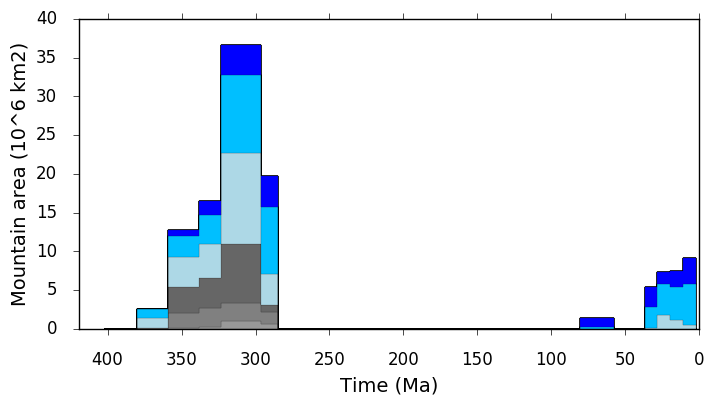

In [85]:
fig, axes = plt.subplots(figsize=(8, 4))

Data1 = pd.read_excel('/Users/wenchaocao/Research/5_ConsistencyRatios_Fossils_Paleogeog/CR_ReconPaleogeog_Matthews2016_AfterGapsFixed_TestByFossils_410_2Ma/CR_ReconPaleogeog_Matthews2016_AfterGapsFixed_TestByFossils_410_2Ma.xlsx', delimiter=',')  
#create an array to install FromAge and ToAge at the same time
TimeStep = np.zeros(len(Data1['From_age'])*2)
TimeStep[::2] = Data1['To_age']
TimeStep[1::2] = Data1['From_age']
print TimeStep


for i in np.arange(0,24,1):
    
    yedges = np.arange(0, 91, 5) #latitude, specify the bin size
    #axes.set_color_cycle(['blue', 'grey'])
    #time = [396,368,348,328,302,287,277,255,232,218,195,169,152,140,126,105,90,76,53,45,33,22,14,6]
    time = [6,14,22,33,43,53,76,90,105,126,140,152,169,195,218,232,255,277,287,302,328,348,368,396]
    
    # mountain
    #cmap = ['blue','deepskyblue','lightblue','grey','grey','darkgrey','darkgrey','lightgrey','lightgrey']
    #cmap = ['blue','deepskyblue','lightblue',(0.4,0.4,0.4),(0.5,0.5,0.5),(0.6,.6,.6),(0.7,0.7,0.7),(0.8,0.8,0.8),(0.9,0.9,0.9)]    
    
    # shallow marine color scheme
    #cmap= [(0.1,0.1,0.1),(0.2,0.2,0.2),(0.3,0.3,0.3),(0.4,0.4,0.4),(0.5,0.5,0.5),(0.6,.6,.6),(0.7,0.7,0.7),(0.8,0.8,0.8),(0.9,0.9,0.9)]
    
    # ice sheet
    cmap = [(0.9,0.9,0.9),(0.8,0.8,0.8),(0.7,0.7,0.7),(0.6,.6,.6),(0.5,0.5,0.5),(0.4,0.4,0.4),'lightblue','deepskyblue','blue']
    
    
    y_all = np.zeros((9,len(np.float64(Ice[0])/196608*510)*2))
    
    for i in np.arange(0,9,1):

        y = np.zeros(len(np.float64(Ice[i])/196608*510)*2)
        y[::2] = np.float64(Ice[i])/196608*510
        y[1::2] = np.float64(Ice[i])/196608*510
        y_all[i] = y
    
    # x-axis: time intervals
    axes.stackplot(TimeStep, y_all,colors=cmap,linewidth=0.1) #edgecolor='grey', , cmap='winter'
    
    # x-axis: reconstruction times
    #axes.stackplot(np.hstack(time), np.float64(m)/196608*510,colors=cmap,linewidth=0.1) #edgecolor='grey', , cmap='winter'

    axes.set_xlim((419,0))
    axes.set_ylim(ymin=0)
    axes.set_ylabel('Mountain area (10^6 km2)',size=14)
    axes.set_xlabel('Time (Ma)',size=14)
    
    axes.xaxis.set_tick_params(labelsize=12,direction='out')
    plt.setp(axes.get_xticklabels(), fontsize=12.) #,rotation=50

    axes.yaxis.set_tick_params(labelsize=12,direction='out')
    axes.xaxis.set_ticks_position('both')
    axes.yaxis.set_ticks_position('left')
    
plt.savefig('i_Areas_timeintervals.pdf',dpi=600)
plt.show

[   2.   11.   11.   20.   20.   29.   29.   37.   37.   49.   49.   58.
   58.   81.   81.   94.   94.  117.  117.  135.  135.  146.  146.  166.
  166.  179.  179.  203.  203.  224.  224.  248.  248.  269.  269.  285.
  285.  296.  296.  323.  323.  338.  338.  359.  359.  380.  380.  402.]


<function matplotlib.pyplot.show>

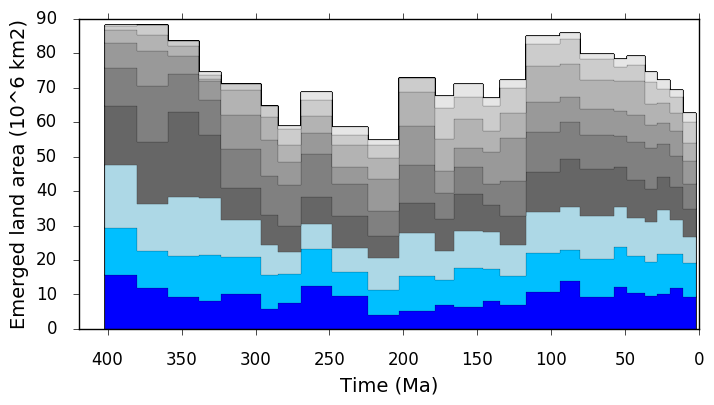

In [86]:
fig, axes = plt.subplots(figsize=(8, 4))

Data1 = pd.read_excel('/Users/wenchaocao/Research/5_ConsistencyRatios_Fossils_Paleogeog/CR_ReconPaleogeog_Matthews2016_AfterGapsFixed_TestByFossils_410_2Ma/CR_ReconPaleogeog_Matthews2016_AfterGapsFixed_TestByFossils_410_2Ma.xlsx', delimiter=',')  
#create an array to install FromAge and ToAge at the same time
TimeStep = np.zeros(len(Data1['From_age'])*2)
TimeStep[::2] = Data1['To_age']
TimeStep[1::2] = Data1['From_age']
print TimeStep


for i in np.arange(0,24,1):
    
    yedges = np.arange(0, 91, 5) #latitude, specify the bin size
    #axes.set_color_cycle(['blue', 'grey'])
    #time = [396,368,348,328,302,287,277,255,232,218,195,169,152,140,126,105,90,76,53,45,33,22,14,6]
    time = [6,14,22,33,43,53,76,90,105,126,140,152,169,195,218,232,255,277,287,302,328,348,368,396]
    
    #cmap = ['blue','deepskyblue','lightblue','grey','grey','darkgrey','darkgrey','lightgrey','lightgrey']
    #cmap = ['blue','deepskyblue','lightblue','grey','lightgrey','grey','lightblue','deepskyblue','blue']
    
    # shallow marine color scheme
    #cmap= [(0.1,0.1,0.1),(0.2,0.2,0.2),(0.3,0.3,0.3),(0.4,0.4,0.4),(0.5,0.5,0.5),(0.6,.6,.6),(0.7,0.7,0.7),(0.8,0.8,0.8),(0.9,0.9,0.9)]
    cmap = ['blue','deepskyblue','lightblue',(0.4,0.4,0.4),(0.5,0.5,0.5),(0.6,.6,.6),(0.7,0.7,0.7),(0.8,0.8,0.8),(0.9,0.9,0.9)]    

    
    y_all = np.zeros((9,len(np.float64(sm[0])/196608*510)*2))
    
    for i in np.arange(0,9,1):

        y = np.zeros(len(np.float64(sm[i])/196608*510)*2)
        y[::2] = np.float64(sm[i])/196608*510
        y[1::2] = np.float64(sm[i])/196608*510
        y_all[i] = y
        #axes.fill_between(TimeStep,0,y,facecolor=cmap[0],linewidth=0.6)
    
    axes.stackplot(TimeStep, y_all,colors=cmap,linewidth=0.1) #edgecolor='grey', , cmap='winter'

    #axes.stackplot(np.hstack(time), np.float64(sm)/196608*510,colors=cmap,linewidth=0.1) #edgecolor='grey', , cmap='winter'

    axes.set_xlim((419,0))
    axes.set_ylim(ymin=0)
    axes.set_ylabel('Emerged land area (10^6 km2)',size=14)
    axes.set_xlabel('Time (Ma)',size=14)
    
    axes.xaxis.set_tick_params(labelsize=12,direction='out')
    plt.setp(axes.get_xticklabels(), fontsize=12.) #,rotation=50

    axes.yaxis.set_tick_params(labelsize=12,direction='out')
    axes.xaxis.set_ticks_position('both')
    axes.yaxis.set_ticks_position('left')
    
    
plt.savefig('sm_Areas_1.pdf',dpi=600)
plt.show

In [179]:
df = pd.DataFrame(m_filpped)
writer = pd.ExcelWriter('m_filpped.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

In [185]:
df = pd.DataFrame(np.array(m_addup))
writer = pd.ExcelWriter('m_filpped_addup.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1')
writer.save()

36
0
2
4
6
8
10
12
14
16
[[0, 1, 187, 38, 113, 144, 154, 207, 574, 457, 558, 831, 347, 582, 531, 696, 448, 94, 41, 0, 0, 0, 0, 0], [415, 609, 656, 679, 738, 1036, 1597, 1242, 1234, 345, 283, 941, 694, 537, 617, 918, 1191, 1017, 535, 0, 181, 112, 1, 648], [934, 1144, 1053, 2018, 1971, 2185, 1702, 2061, 1090, 639, 586, 672, 882, 713, 366, 858, 607, 997, 1048, 201, 975, 2254, 905, 822], [1023, 1313, 1755, 2367, 2248, 982, 1150, 1618, 2637, 1608, 881, 958, 743, 304, 287, 731, 697, 1293, 1422, 1947, 2598, 4630, 4064, 702], [1915, 2120, 1749, 1610, 1393, 1008, 1313, 1634, 2465, 1906, 1190, 886, 1290, 1005, 1218, 2546, 2028, 2186, 2169, 2830, 3522, 3732, 5045, 1120], [1437, 1691, 1303, 1535, 1438, 2081, 2153, 1906, 1485, 1107, 973, 893, 1201, 1436, 1477, 1177, 1766, 2175, 2336, 3294, 3626, 3895, 4670, 1456], [1441, 1854, 1818, 1256, 1187, 1427, 1307, 1082, 654, 593, 1036, 1099, 1402, 549, 639, 1304, 1044, 2038, 1886, 2223, 2610, 2834, 3180, 1062], [1486, 1629, 834, 1107, 1017, 1281, 1049, 122

<function matplotlib.pyplot.show>

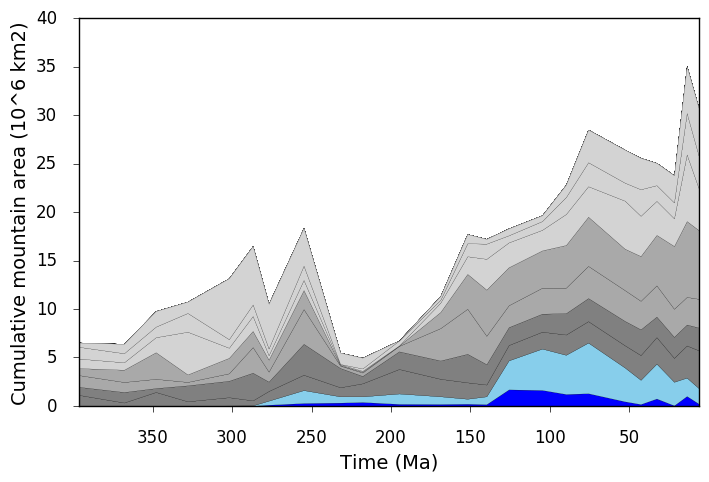

In [51]:
fig, axes = plt.subplots(figsize=(8, 5))

for i in np.arange(0,24,1):
    
    yedges = np.arange(0, 91, 5) #latitude, specify the bin size
    #axes.set_color_cycle(['blue', 'grey'])
    time = [6,14,22,33,43,53,76,90,105,126,140,152,169,195,218,232,255,277,287,302,328,348,368,396]
    
    color = ['blue','skyblue','grey','grey','darkgrey','darkgrey','lightgrey','lightgrey','lightgrey']
    
    axes.stackplot(np.hstack(time), np.float64(Ice)/196608*510,colors=color,linewidth=0.1) #edgecolor='grey', , cmap='winter'
    
    axes.set_xlim((396,6))
    axes.set_ylim(ymin=0)
    axes.set_ylabel('Cumulative mountain area (10^6 km2)',size=14)
    axes.set_xlabel('Time (Ma)',size=14)
    
    axes.xaxis.set_tick_params(labelsize=12,direction='out')
    plt.setp(axes.get_xticklabels(), fontsize=12.) #,rotation=50

    axes.yaxis.set_tick_params(labelsize=12,direction='out')
    axes.xaxis.set_ticks_position('bottom')
    axes.yaxis.set_ticks_position('left')


#plt.savefig('MountainRange_Areas.pdf',dpi=600)
plt.show